based on the source code, this model uses pre-trained model based on "iNaturalist" which spealizes in plants and wild animal species ( aka. potenial use of segmeation model + active learning ) 

(source code : https://www.tensorflow.org/hub/tutorials/image_feature_vector#train_the_network)

why tesorflow:
- easier tutuorials 
- enables more NN costomization 

### Setup 

In [ ]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()   # no need for the old v1 
import tensorflow as tf
import tensorflow_hub as hub


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

### The flowers dataset ( repalce this part )

The flowers dataset consists of images of flowers with 5 possible class labels.( similar style as leaves DataSet)

In [ ]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8  # a bit much maybe it can be reduced to 0,75
RANDOM_SEED = 2000

## setting dowload function 

def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes

In [ ]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


### optional (showing samples of the Dataset)

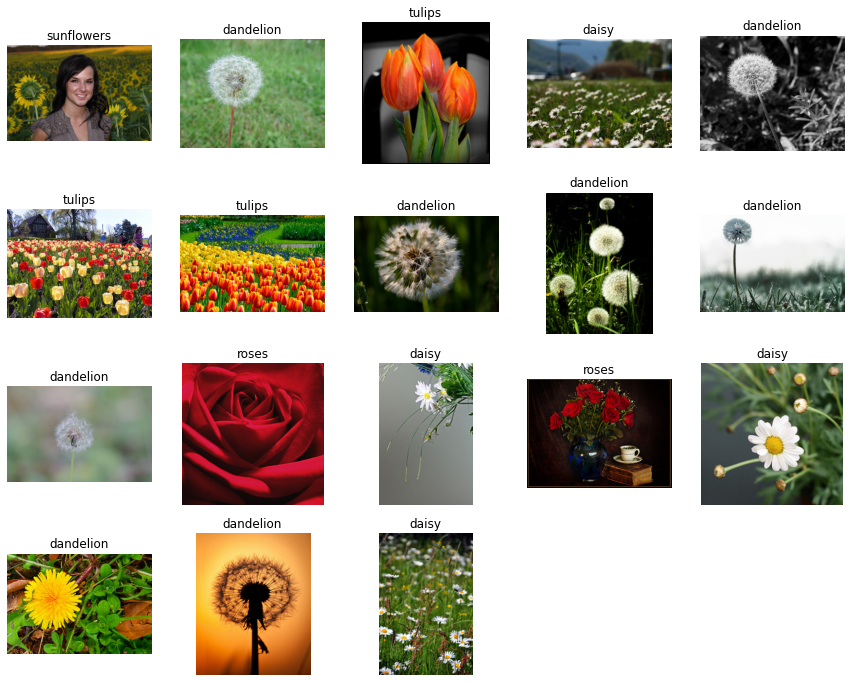

In [ ]:
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 18
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

### leaves Dataset 

In [ ]:
!curl -O https://zenodo.org/record/4446955/files/Leaves.zip

!unzip -q Leaves.zip
!ls

!ls Leaves



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  135M  100  135M    0     0  4191k      0  0:00:33  0:00:33 --:--:-- 3248k
flower_photos  flower_photos.tgz  Leaves  Leaves.zip  sample_data
 Ash   Beech   Hornbeam  'Mountain oak'  'Sycamore maple'


In [ ]:
species = ['Ash' ,  'Beech'  , 'Hornbeam' , 'Mountain oak' , 'Sycamore maple']

In [ ]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names":species}

### create train & test 

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    "Leaves",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "Leaves",
  subset="validation",
    **args
)

Found 122 files belonging to 5 classes.
Using 98 files for training.
Found 122 files belonging to 5 classes.
Using 24 files for validation.


In [ ]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Train the model 

- using pre-trained model from inaturalist as a base then fine tune it 
- (maybe) use data augmnetation 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
def train_model(network, epochs=5):
    model = Sequential(network)

    model.compile(
        optimizer='adam', # how to predict error/ tries to minimize error 
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
        )
    
    ## alternative Model compiling
    #model.compile(
    #    optimizer='rmsprop',
    #    loss='binary_crossentropy',
    #    metrics=['accuracy']
    #    )

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [ ]:
network_1 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(5, activation='softmax')
])

network_1.build([None, 299, 299, 3])

In [ ]:
history_df, model = train_model(network_1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 4 steps, validate on 1 steps
Epoch 1/5
4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 1.0000 - loss: 0.5358 - acc: 0.8163

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4/4 [==============================] - 27s 6s/step - batch: 1.5000 - size: 1.0000 - loss: 0.5358 - acc: 0.8163 - val_loss: 1.5634 - val_acc: 0.7083
Epoch 2/5
4/4 [==============================] - 19s 4s/step - batch: 1.5000 - size: 1.0000 - loss: 0.3489 - acc: 0.8571 - val_loss: 0.2411 - val_acc: 0.9583
Epoch 3/5
4/4 [==============================] - 22s 5s/step - batch: 1.5000 - size: 1.0000 - loss: 0.2768 - acc: 0.9388 - val_loss: 0.5311 - val_acc: 0.8750
Epoch 4/5
4/4 [==============================] - 20s 5s/step - batch: 1.5000 - size: 1.0000 - loss: 0.0262 - acc: 0.9898 - val_loss: 0.8659 - val_acc: 0.8333
Epoch 5/5
4/4 [==============================] - 23s 4s/step - batch: 1.5000 - size: 1.0000 - loss: 0.1064 - acc: 0.9694 - val_loss: 1.2040 - val_acc: 0.7917


### results display

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   multiple                  21813029  
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


I have non-trainable parmeters, what does this mean???

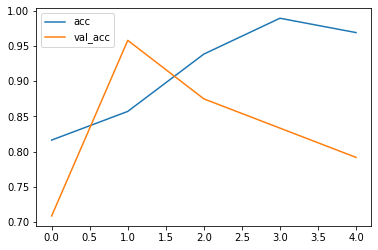

In [ ]:
history_df[["acc", "val_acc"]].plot()

In [ ]:
# showing results  ( refactoring of the code)

def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

NameError: ignored